## Example of Groundwater Flow Simulation with FloPy

Generates an unconditional Gaussian simulation with ```geostatspy``` to create a synthetic two-dimensional aquifer with heterogeneous hydraulic conductivity. Groundwater flow is simulated with MODFLOW 6 and ```flopy```, and the streamlines are calculated with MODPATH 7. This workflow allows to evaluate the impact of different geostatistics on the flow streamlines. 

**Note 1:** The executable ```sgsim.exe``` must be available in the system or project folder.

**Note 2:** The MODFLOW 6 (```mf6.exe```) and MODPATH 7 (```mp7.exe```) executables must also be accessible at the system level or placed in the project directory.

## Resources
* [flopy](https://github.com/modflowpy/flopy)
* [flopyrw](https://github.com/upc-ghs/flopyrw)
* [MODPATH-RW](https://github.com/upc-ghs/modpath-rw)
* [modflow 6](https://github.com/MODFLOW-USGS/modflow6)
* [modflow executables](https://github.com/MODFLOW-USGS/executables)
* [modpath-v7](https://github.com/MODFLOW-USGS/modpath-v7)
* [modpath-omp](https://github.com/upc-ghs/modpath-omp)
* [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)
* [GSLIB executables](https://github.com/upc-ghs/gslib-executables)

In [1]:
'''
Example application generating Gaussian simulation 
for the hydraulic conductivity field using the wrapper of GeostatsPy. 
The generated field is then passed to flopy to configure and run 
a groundwater flow model with MODFLOW 6.

@note:
    - Download the MODFLOW executables: https://github.com/MODFLOW-USGS/executables
    - Requires GSLIB >= 2.907 (http://www.gslib.com/main_gd.html) 
    - Documentation for GSLIB:
        Deutsch, C.V. and Journel, A.G., (1997). GSLIB Geostatistical Software Library and
        User’s Guide, Oxford University Press, New York, second edition. 369 pages.
'''


# python packages
import os 
import numpy as np
import matplotlib.pyplot as plt


# routine parameters
write_run_files = True # generate new files for all simulations


In [2]:
# Check and install required packages if not already installed
import sys
import subprocess

def if_require(package):
    try:
        __import__(package)
    except ImportError:
        print(f"{package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        
# Install packages only if they aren't already installed
if_require("geostatspy")
if_require("tqdm")
if_require("numba")
if_require("statsmodels")

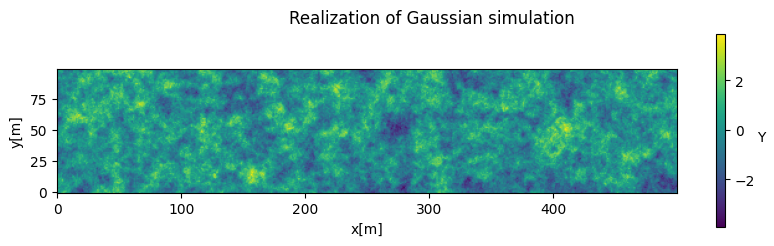

In [ ]:
#------------------------------------------------------------#
# Realization for the hydraulic conductivity with GeostatsPy # 
#------------------------------------------------------------#

# Geostatspy
from geostatspy import geostats
from geostatspy import GSLIB

# grid data
nx       = 500  # number of cells in x
ny       = 100  # number of cells in y 
cellsize = 1    # cell size, assumed unitary

# create a variogram object
vario = GSLIB.make_variogram(
        nug   = 0.0,  # nugget effect
        nst   = 1,    # number of nested structures
        it1   = 2,    # type of nested structures (1=sph,2=exp,3=gau,4=pow) 
        cc1   = 1.0,  # multiplicative factor for nested structure 
        azi1  = 0.0,  # azimuth angle
        hmaj1 = 20,   # isotropic 
        hmin1 = 20,   #
        #azi1  = 90.0,
        #hmaj1 = 50,   # anisotropic 
        #hmin1 = 10,   #
    )

# calculate unconditional stochastic realization with standard normal distribution
seed     = 73073 # for random number generation
nreal    = 1     # number of realizations of the Gaussian simulation
outfile  = 'simulation.out'
if write_run_files:
    # this routine will write and run a new Gaussian simulation
    gaussian_sim = GSLIB.sgsim_uncond(
            nreal,
            nx   ,
            ny   ,
            cellsize,
            seed,
            vario,
            outfile, 
        )
else:
    # try to load a previously generated file
    gaussian_sim = GSLIB.GSLIB2ndarray(outfile,0,nx,ny)[0] 

# plot the generated Gaussian simulation
fig  = plt.figure(figsize=(10,2.5))
ax   = fig.add_subplot(111)
im   = ax.imshow( gaussian_sim[::-1,:], origin='lower' )
cbar = fig.colorbar(im)
cbar.set_label('Y', rotation=0)
ax.set_aspect('equal')
ax.set_xlabel('x[m]')
ax.set_ylabel('y[m]')

fig.suptitle('Realization of Gaussian simulation')

# save figure with realization
fig.savefig('gaussiam_sim.png')

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model mf6model...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package chd_0...
    writing package ic...
    writing package oc...
FloPy is using the following executable to run the model: ..\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and 

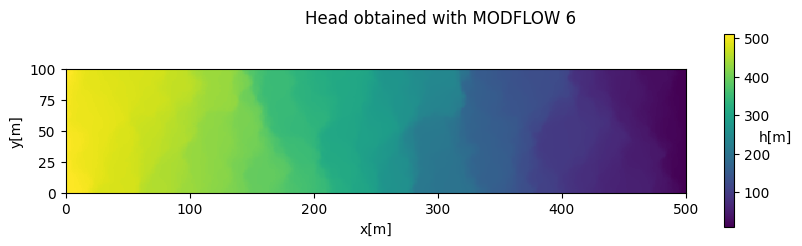

In [4]:

#---------------------------------------------#
# MODFLOW 6 groundwater flow model with FloPy # 
#---------------------------------------------#
import flopy


# Configure the MODFLOW-6 model #
simname   = 'mprwexsim'
modelname = 'mf6model'
simws     = os.path.join( os.getcwd(), simname )

# sim 
sim = flopy.mf6.MFSimulation(
        sim_name = simname,
        sim_ws   = simws,
        exe_name = 'mf6'  # update the executable name/path to your system 
    )

# time discretization package (steady state)
stress_periods = [
        {
            'id'           : 0,
            'length'       : 100, # units of time (e.g., days)
            'n_time_steps' : 1, 
            'ts_multiplier': 1,
            'steady_state' : True
        },
    ]
perioddata = []
for sp in stress_periods:
    perioddata.append( [sp['length'], sp['n_time_steps'], sp['ts_multiplier']] )
tdis = flopy.mf6.ModflowTdis(
    sim,
    nper=len(stress_periods),
    perioddata=perioddata,
)

# iterative model solver package
# solver parameters
hclose = 1e-5
ninner = 500 
nouter = 100
ims = flopy.mf6.ModflowIms(
        sim,
        pname               = 'ims',
        print_option        = 'SUMMARY',
        complexity          = 'MODERATE',
        inner_maximum       = ninner,
        inner_dvclose       = hclose, 
        linear_acceleration = 'BICGSTAB',
        scaling_method      = 'NONE',
        reordering_method   = 'NONE',
        relaxation_factor   = 0.97,
        outer_maximum       = nouter, 
        outer_dvclose       = hclose,
        no_ptcrecord        = ['ALL'], 
    )

# groundwater flow package
gwf = flopy.mf6.ModflowGwf(
    sim,                                     
    modelname=modelname,
    save_flows=True,
    newtonoptions=['UNDER_RELAXATION'], # Newton
)

# model grid discretization package 
nlay       = 1
nrow       = ny
ncol       = nx
dis = flopy.mf6.ModflowGwfdis(
        gwf, 
        nlay = nlay,
        nrow = nrow,
        ncol = ncol, 
        delr=1, delc=1, top=1, botm=0, 
    )

# node property flow package
# define the hydraulic condudctivity distribution based on the gaussian simulation
hkvariance = 3.5  
hkarray    = np.exp( np.sqrt(hkvariance)*gaussian_sim.reshape(nlay,nrow,ncol) ) # assume meters/day
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_specific_discharge=True, 
    icelltype=0,
    k=hkarray,
)

# constant head package 
# unit mean gradient
hdin   = ncol+10
hdout  = 10
chdspd = []
for ir in range(nrow):
    chdspd.append( [ (0, ir,    0), hdin  ] )
    chdspd.append( [ (0, ir, ncol-1), hdout ] )
chd = flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chdspd, 
        maxbound=len(chdspd),
    )

# initial conditions package (the starting values for the iterative solver)
# linear initial condition for each row
icarray= np.zeros(shape=(nlay,nrow,ncol), dtype=np.float64 )
xcoord = np.arange( 0, ncol, 1 ) 
for ir in range(nrow): 
    icarray[0,ir,:] = ( 1 - xcoord/ncol)*hdin + xcoord/ncol*hdout
ic = flopy.mf6.ModflowGwfic(
        gwf,
        strt=icarray,
    )

# output control package
budget_file = modelname + '.bud'
head_file   = modelname + '.hds'
flopy.mf6.ModflowGwfoc(
        gwf,
        budget_filerecord=budget_file,
        head_filerecord  =head_file,
        saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')]
    )

if write_run_files:
    # write MODFLOW 6 files
    sim.write_simulation()
    # run MODFLOW 6 files
    success, mf6_output = sim.run_simulation(pause=False, report=True)
    if not success:
        raise Exception('MF6 did not terminate normally !')

# plot head calculated with MODFLOW 6
hfile = flopy.utils.HeadFile(os.path.join(simws,head_file))
times = hfile.get_times()
hdata = hfile.get_data(totim=times[-1])
fig   = plt.figure(figsize=(10,2.5))
ax    = fig.add_subplot(111)
pmv   = flopy.plot.PlotMapView(gwf,ax=ax)
im    = pmv.plot_array(hdata)
cbar  = fig.colorbar(im)
cbar.set_label('h[m]', rotation=0)
ax.set_aspect('equal')
ax.set_xlabel('x[m]')
ax.set_ylabel('y[m]')
fig.suptitle('Head obtained with MODFLOW 6')
fig.savefig('modflow_head.png')

FloPy is using the following executable to run the model: ..\mp7.EXE

MODPATH Version 7.2.001   
Program compiled Jun 21 2024 03:01:44 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+02  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         9 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


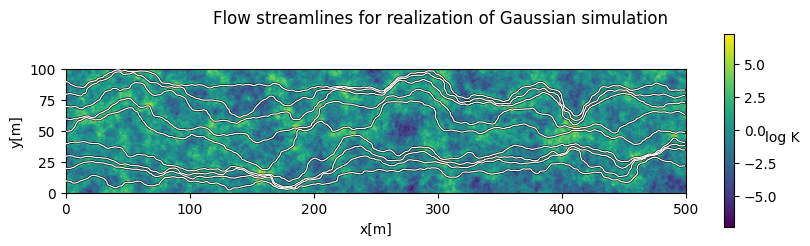

In [5]:
#----------------------------------------#
# MODPATH 7 particle tracking with FloPy # 
#----------------------------------------#


# build particle positions
locs = []

# place particles on the initial column (x=0)
# every 10 cells
for ir in range(1,nrow):
    if ir%10 == 0:
        locs.append( # layer, row, column
                (0, ir, 0),
            )
particledata = flopy.modpath.ParticleData(
        locs,
        structured=True,
        drape =0,
        localx=0.5,
        localy=0.5,
        localz=0.5
    )
# build particle group
releasetime = 0.0
particlegroup = flopy.modpath.ParticleGroup(
        particlegroupname = 'PG0',
        particledata      = particledata,
        releasedata       = releasetime, 
    )

# create the modpath 7 model
mpath = flopy.modpath.Modpath7(
        modelname = 'mpathsim',
        flowmodel = gwf,
        model_ws  = simws,
        exe_name  = 'mp7', # update the executable name/path to your system 
    )

# basic package (porosity)
# assume constant porosity in this case 
porosity = 0.35
flopy.modpath.Modpath7Bas(
        mpath,
        porosity=porosity, 
    )

# create the modpath 7 simulation
pathlinefname = 'mpathsim.pathline'
flopy.modpath.Modpath7Sim(
        mpath,
        simulationtype    = 'pathline', # for streamlines generation
        trackingdirection = 'forward', 
        weaksinkoption    = 'stop_at', 
        weaksourceoption  = 'pass_through', 
        stoptimeoption    = 'extend', 
        particlegroups    = [ particlegroup ], 
        pathlinefilename  = pathlinefname, 
    )

if write_run_files:
    # write modpath files
    mpath.write_input()
    # run modpath files
    success, buff = mpath.run_model(silent=False, report=False)
    assert success, "mp7 tracking failed to run"
    for line in buff:
        print(line)

# draw flow streamlines on top of Gasussian realization
fig     = plt.figure(figsize=(10,2.5))
ax      = fig.add_subplot(111)
hkarray = npf.k.array
im      = ax.imshow( np.log(hkarray[0,::-1,:]), origin='lower' )
cbar = fig.colorbar(im)
cbar.set_label('log K', rotation=0)
ax.set_aspect('equal')
ax.set_xlabel('x[m]')
ax.set_ylabel('y[m]')
# load and plot streamlines file
pfile = flopy.utils.PathlineFile( os.path.join( simws, pathlinefname ) )
pids  = np.unique( pfile._data['particleid'] )
for p in pids:
    datap = pfile._data[ pfile._data['particleid'] == p ]
    ax.plot( datap['x'], datap['y'], linewidth=0.9, color='w', zorder=3 )
    ax.plot( datap['x'], datap['y'], linewidth=1.7, color='k', zorder=2 )
ax.set_xlim([0,nx])
ax.set_ylim([0,ny])
fig.suptitle('Flow streamlines for realization of Gaussian simulation')
fig.savefig('gaussian_simulation_streamlines.png')